In [1]:
import statistics, itertools, io, pprint
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM
from statsmodels.multivariate.manova import MANOVA
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [2]:
def score_histogram(data_slice, title):
    score_counts = []
    for score in range(0, 7):
        length = len(data_slice[data_slice['score'] - 1 == score])
        score_counts.append(length)
    plt.bar(range(1, 8), score_counts)
    plt.xticks(range(1, 8))
    plt.xlabel('score')
    plt.ylabel('count')
    plt.title(title)
    plt.savefig('score_histogram.png', dpi=400, format='png')
    plt.show()

In [3]:
data = pd.read_csv('data.csv')
participants = pd.read_csv('participants.csv')

In [4]:
participant_ids = np.sort(participants['id'].unique())
channels = np.sort(data['channel'].unique())
sounds = np.sort(data['sound'].unique())
sample_dict = dict()
for index, pair in enumerate(itertools.product(sounds, channels)):
    sample_dict[pair] = index + 1
pp = pprint.PrettyPrinter()
pp.pprint(sample_dict)

{('glass.wav', 1): 1,
 ('glass.wav', 3): 2,
 ('glass.wav', 5): 3,
 ('glass.wav', 7): 4,
 ('glass.wav', 9): 5,
 ('glass.wav', 11): 6,
 ('glass.wav', 13): 7,
 ('glass.wav', 15): 8,
 ('hog.wav', 1): 9,
 ('hog.wav', 3): 10,
 ('hog.wav', 5): 11,
 ('hog.wav', 7): 12,
 ('hog.wav', 9): 13,
 ('hog.wav', 11): 14,
 ('hog.wav', 13): 15,
 ('hog.wav', 15): 16,
 ('knocking.wav', 1): 17,
 ('knocking.wav', 3): 18,
 ('knocking.wav', 5): 19,
 ('knocking.wav', 7): 20,
 ('knocking.wav', 9): 21,
 ('knocking.wav', 11): 22,
 ('knocking.wav', 13): 23,
 ('knocking.wav', 15): 24}


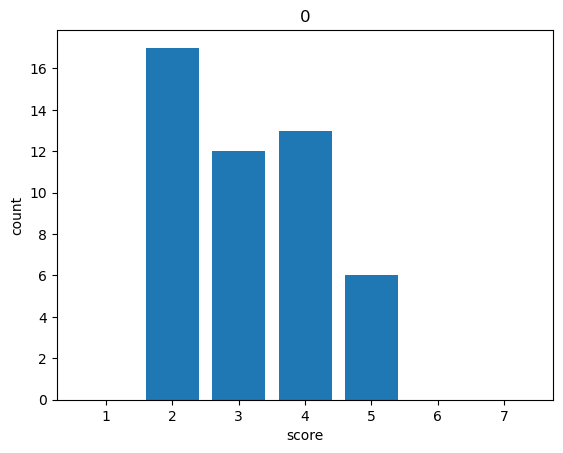

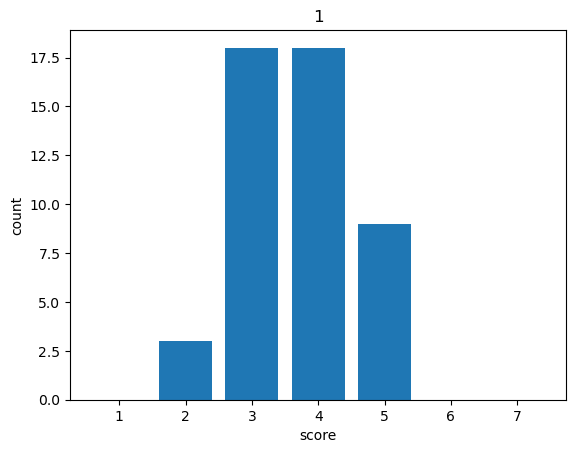

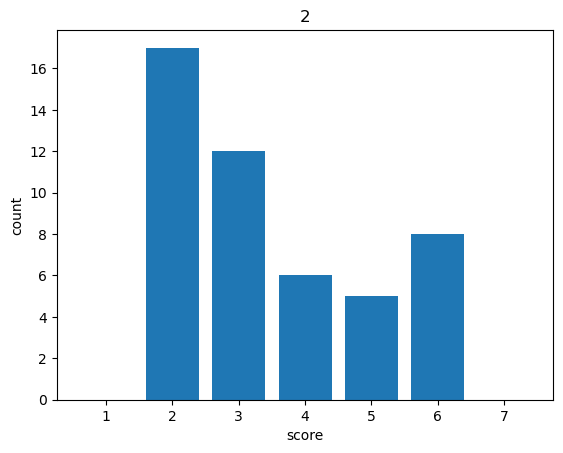

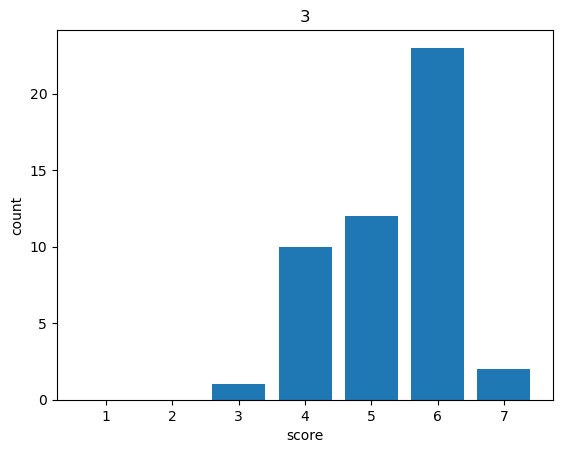

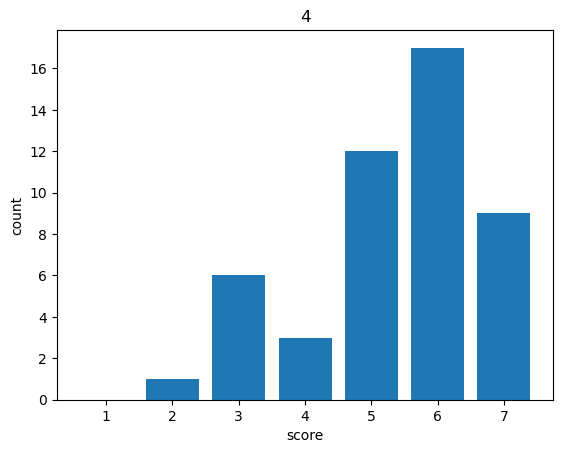

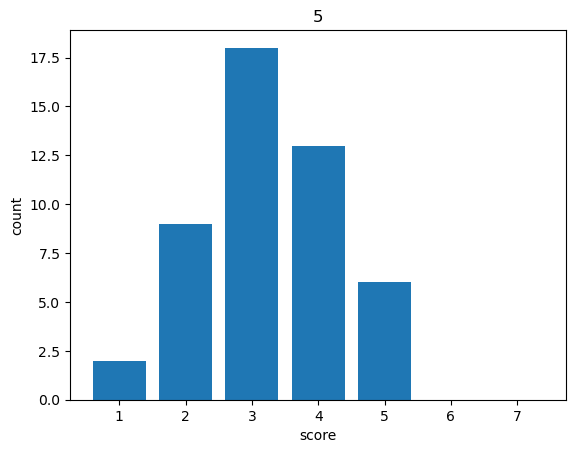

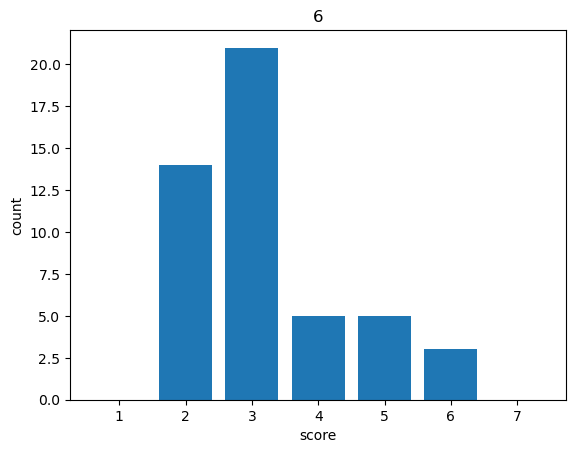

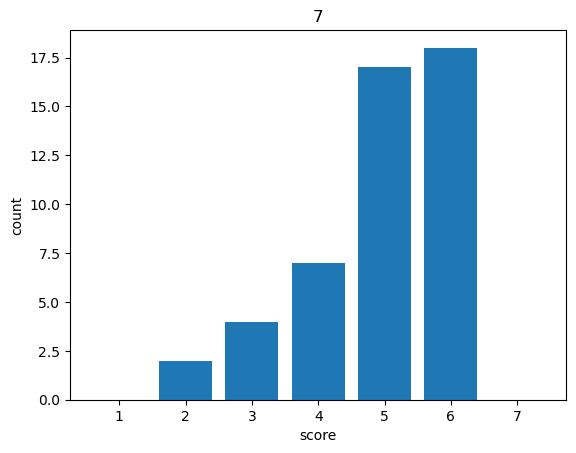

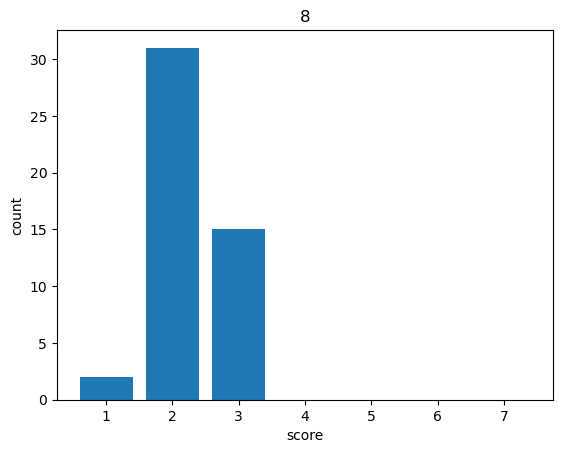

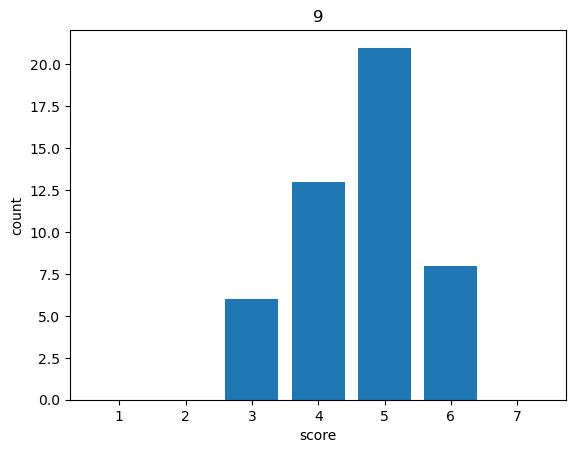

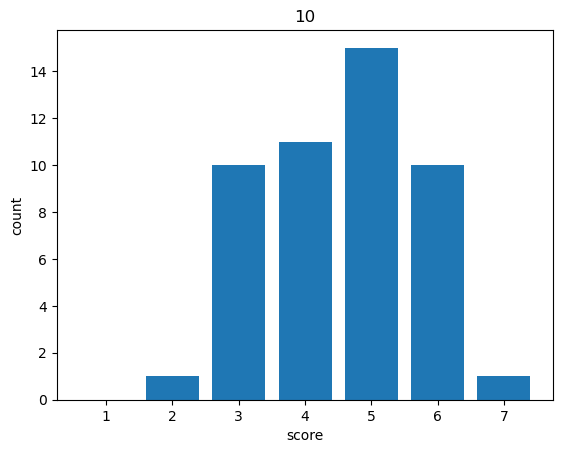

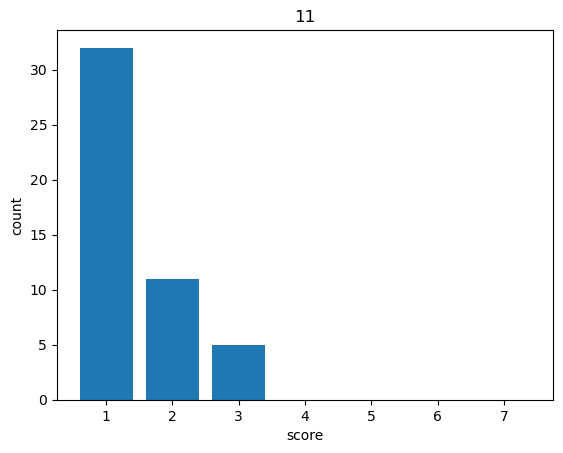

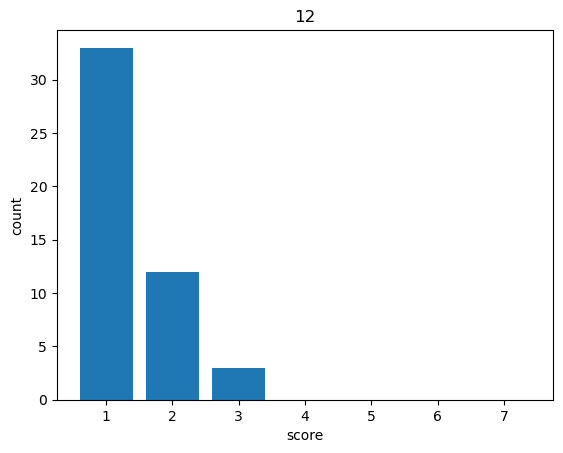

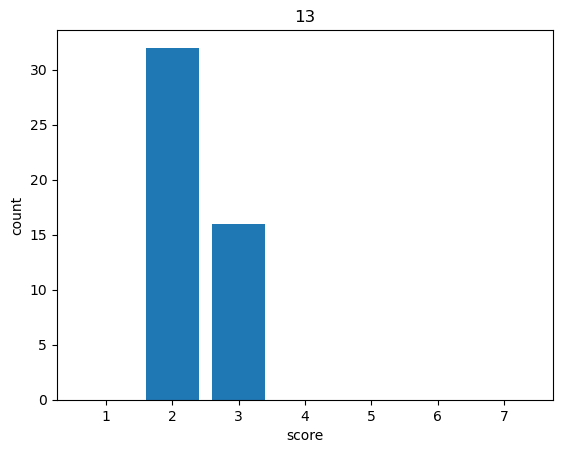

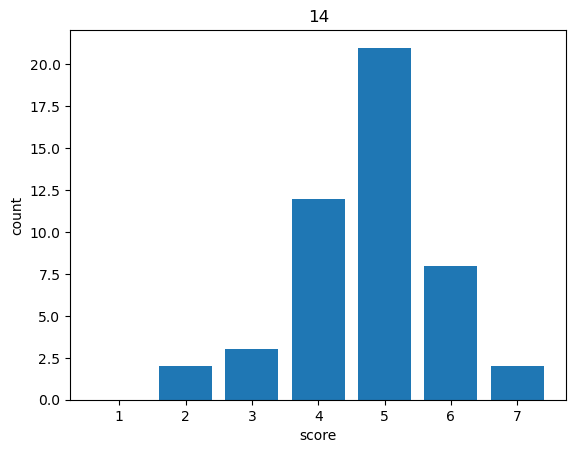

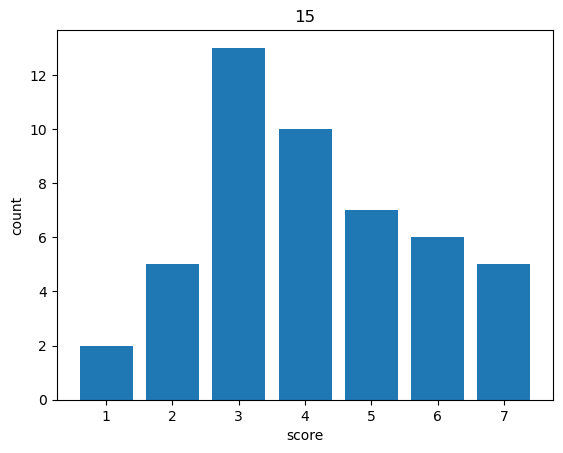

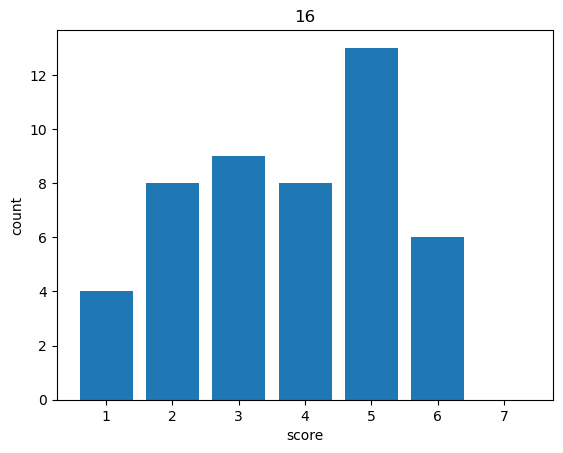

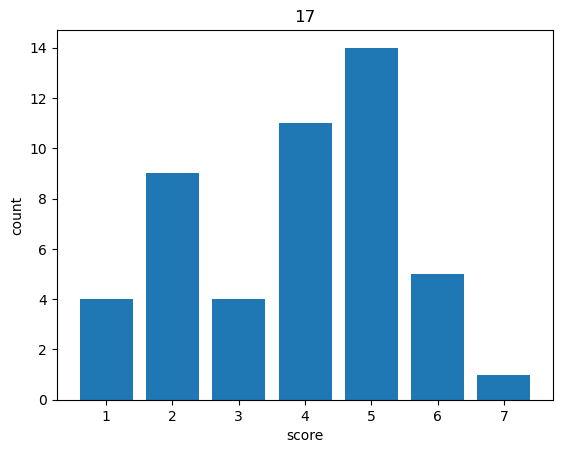

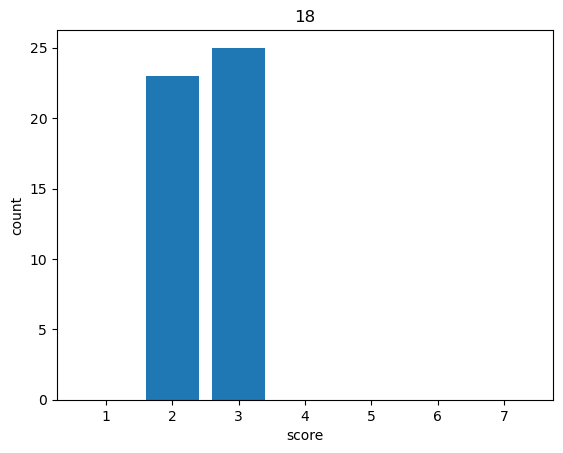

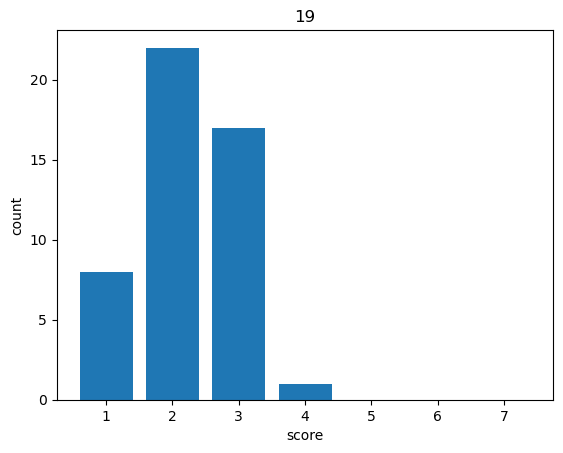

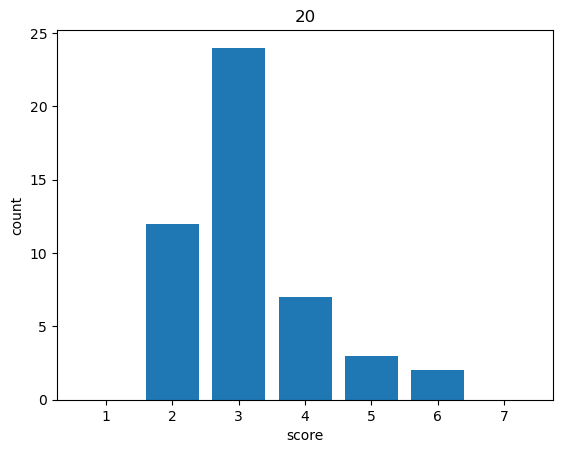

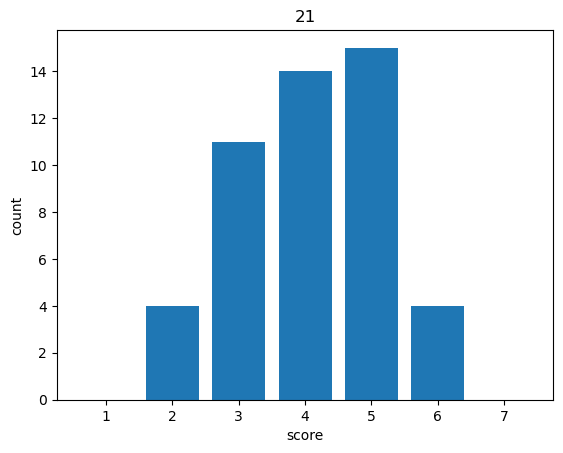

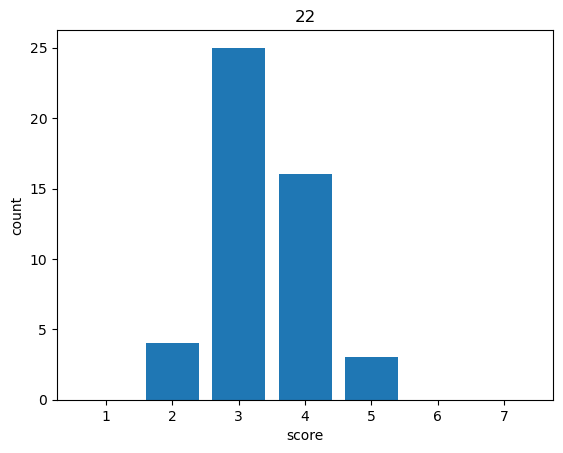

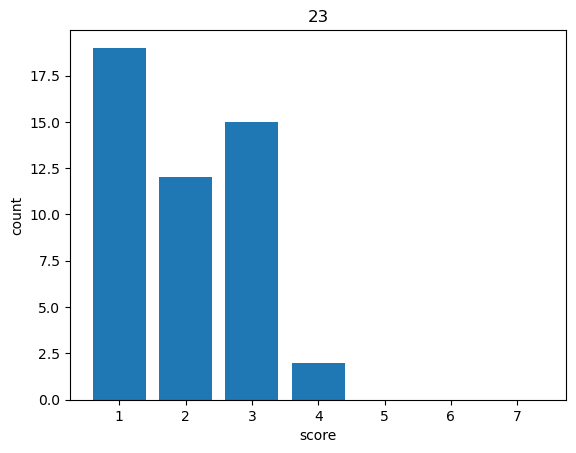

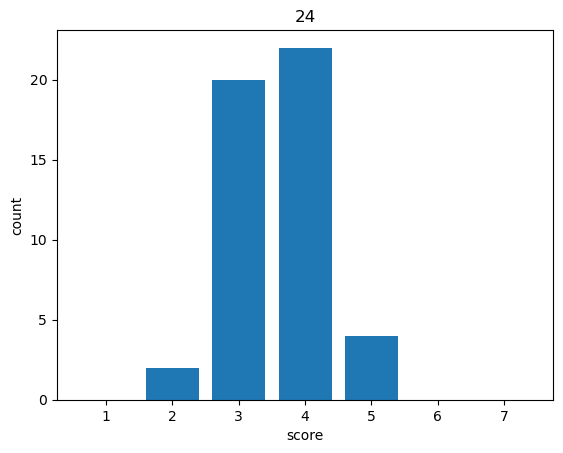

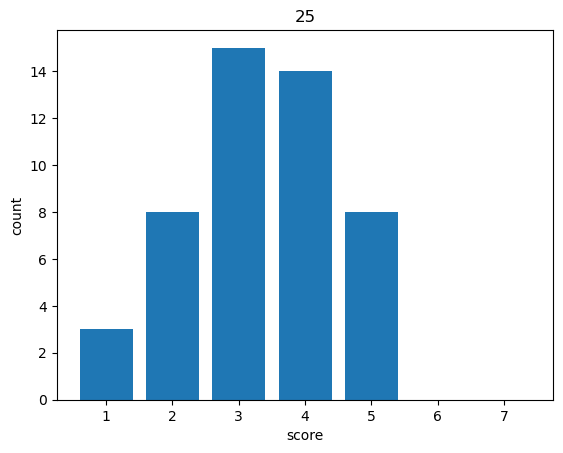

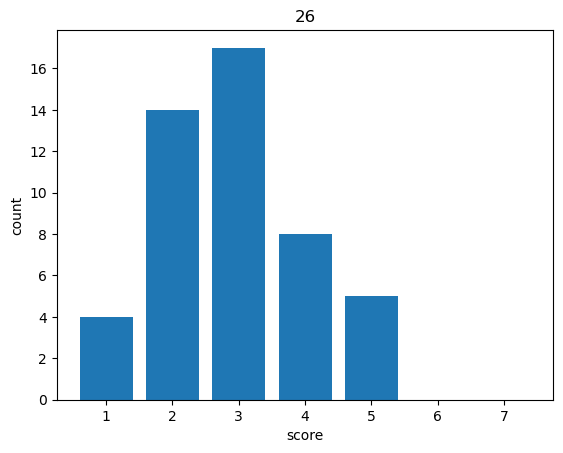

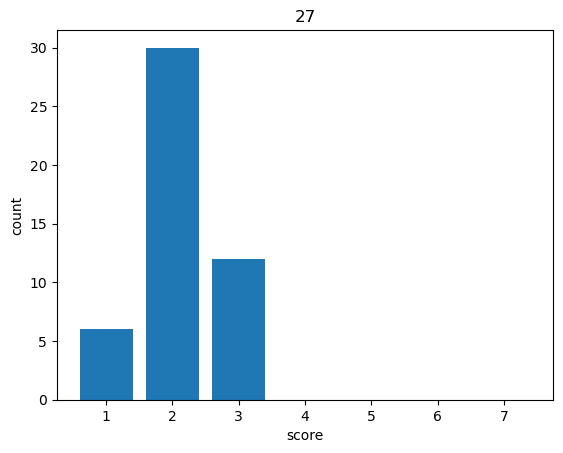

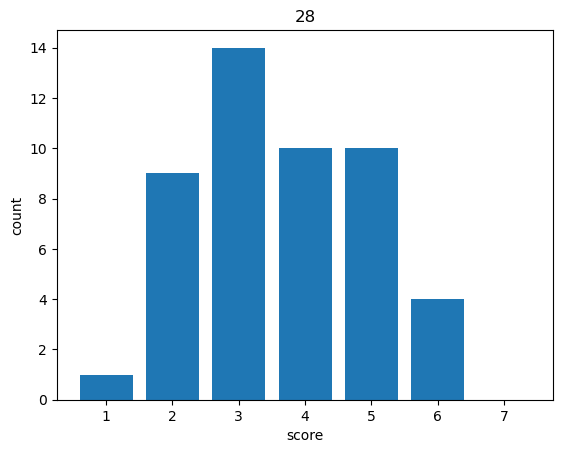

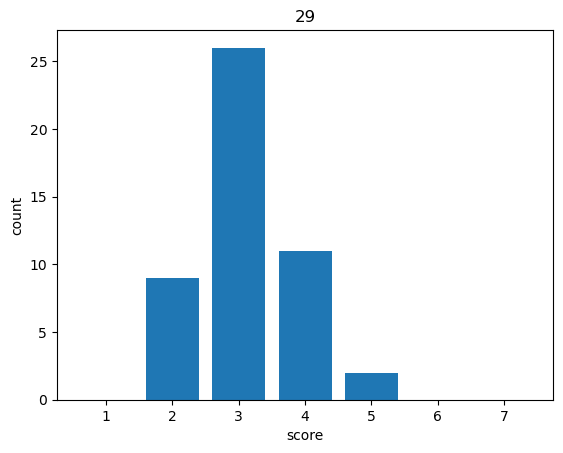

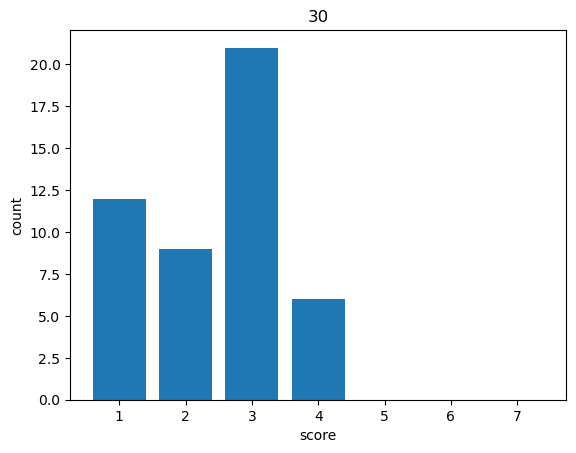

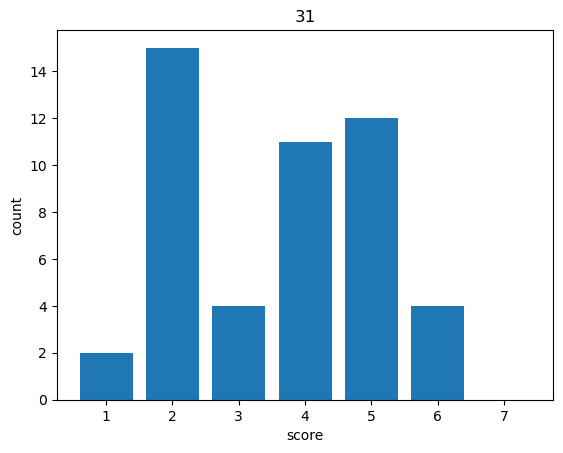

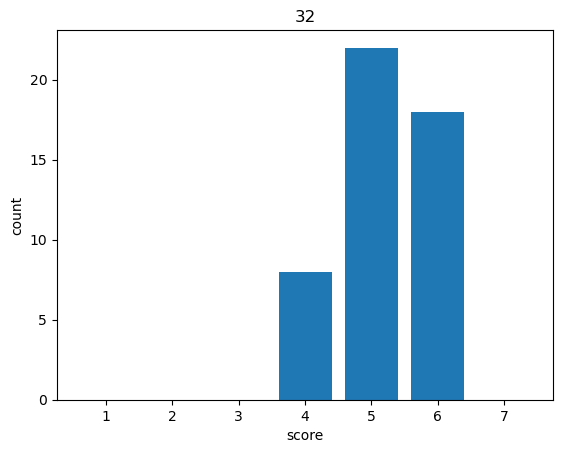

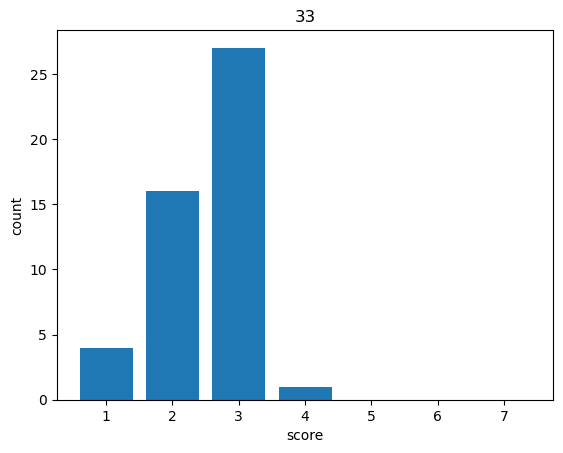

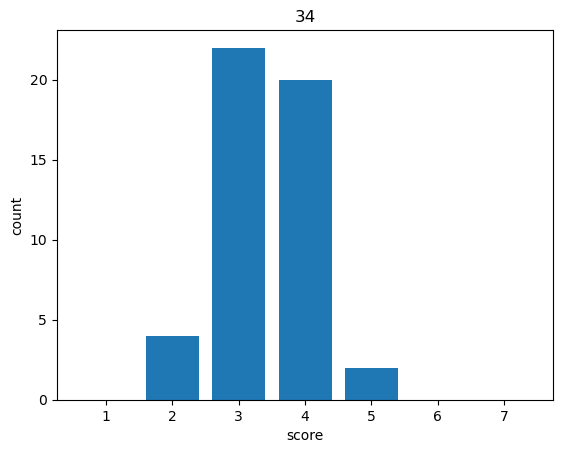

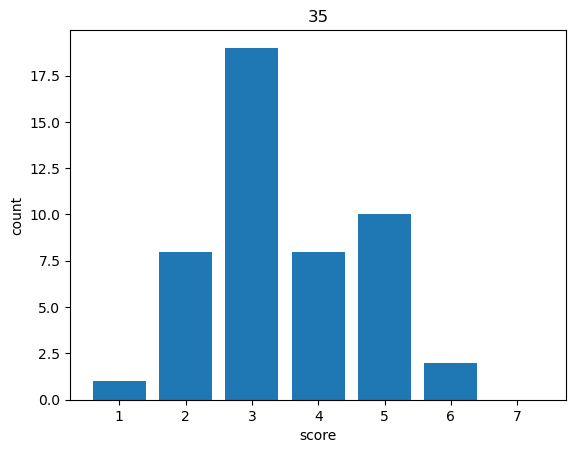

NameError: name 'numpy' is not defined

In [13]:
participants['rmse'] = pd.Series(dtype='float')
data['sample'] = pd.Series(dtype='int')
data['repeat'] = pd.Series(dtype='int')
all_scores = []
for participant in participant_ids:
    data_slice = data[data['participant_id'] == participant]
    group_indexes = data_slice.groupby(['recording', 'channel']).groups.values()
    first_scores = []
    second_scores = []
    for index_pair in group_indexes:
        first_attempt = data.loc[index_pair[0]]
        second_attempt = data.loc[index_pair[1]]
        
        sample = (first_attempt['recording'], first_attempt['channel'])
        sample_id = sample_dict[sample]
        data.loc[index_pair, 'sample'] = sample_id
        data.loc[index_pair[0], 'repeat'] = 0
        data.loc[index_pair[1], 'repeat'] = 1
        
        first_scores.append(first_attempt['score'])
        second_scores.append(second_attempt['score'])
    
    rmse = mean_squared_error(first_scores, second_scores, squared=False)
    model = ols('score ~ C(angle)', data=data_slice).fit()
    f = sm.stats.anova_lm(model, typ=1).F[0]
    
    participants.loc[participants['id'] == participant, 'rmse'] = rmse
    participants.loc[participants['id'] == participant, 'f'] = f
    score_histogram(data[data['participant_id'] == participant], participant)
    
    all_scores.append(data_slice.sort_values(by=['sample', 'repeat'])['score'])
    
data = data.astype({'sample': 'int', 'repeat': 'int'})
all_scores = numpy.array(all_scores)

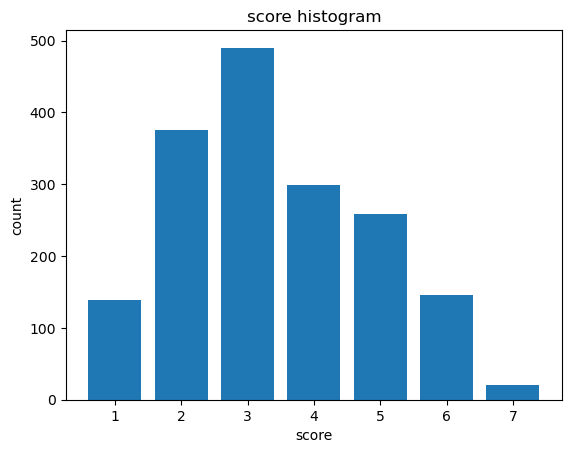

In [453]:
score_histogram(data, 'score histogram')

In [6]:
channels_to_angles_str = {
    1: '0°',
    3: '-45°',
    5: '-90°',
    7: '-135°',
    9: '180°',
    11: '135°',
    13: '90°',
    15: '45°'
}
angles = ['-180°', '-135°', '-90°', '-45°', '0°', '45°', '90°', '135°', '180°']

In [7]:
channels_to_angles = {
    1: 0,
    3: -45,
    5: -90,
    7: -135,
    9: 180,
    11: 135,
    13: 90,
    15: 45
}

In [8]:
channels_to_view = {
    1: True,
    3: True,
    5: False,
    7: False,
    9: False,
    11: False,
    13: False,
    15: True
}

In [189]:
sound_to_id = {
    'glass.wav': 0,
    'hog.wav': 1,
    'knocking.wav': 2
}

In [193]:
inv_sample_dict = {v: k for k, v in sample_dict.items()}
def sample_to_label(sample):
    entry = inv_sample_dict[sample]
    sound = entry[0]
    channel = entry[1]
    return channels_to_angles[channel] + '_' + str(sound_to_id[sound])

In [195]:
data['sample_label'] = data['sample'].map(sample_to_label)

In [10]:
data = data.rename(columns={"sound": "recording"})

In [9]:
data['angle'] = data['channel'].map(channels_to_angles)
data['angle_str'] = data['channel'].map(channels_to_angles_str)
data['view'] = data['channel'].map(channels_to_view)

In [443]:
data = pd.concat([data, data[data['channel']==9].assign(angle_str='-180°')], ignore_index=True)

In [34]:
data = data[['participant_id', 'angle', 'sound', 'channel', 'sample', 'repeat', 'score']]

In [357]:
data = data.rename(columns={'participant_id': 'Listener', 'sound': 'Recording', 'repeat': 'Repetition', 'angle': 'Angle', 'score': 'Score'})
data = data[['Listener', 'Recording', 'Repetition', 'Angle', 'Score']]
data

,Listener,Recording,Repetition,Angle,Score
0,0,knocking.wav,0,-45,3
1,0,knocking.wav,0,-135,4
2,0,knocking.wav,0,135,4
3,0,knocking.wav,1,-45,3
4,0,knocking.wav,0,180,5
...,...,...,...,...,...
1723,35,knocking.wav,1,-135,3
1724,35,knocking.wav,1,-90,4
1725,35,knocking.wav,1,90,5
1726,35,knocking.wav,1,-45,2


In [359]:
data.to_csv('data_panelcheck.csv', index=False)

In [ ]:
data.groupby('angle').boxplot(subplots=False, column='score', grid=False, figsize=(10,5), positions=[1, 0, 3, 2, 4, 7, 8, 5, 6])
plt.xticks(range(0, len(angles)), angles)
plt.xlabel('kąt')
plt.ylabel('ocena')
plt.title('wykres pudełkowy')
plt.savefig('boxplot.png', dpi=400, format='png')
plt.show()

In [ ]:
sounds = data['sound'].unique()

for sound in sounds:
    data[data['participant_id']==sound].groupby('angle').boxplot(subplots=False, column='score', grid=False, figsize=(10,5), positions=[1, 0, 3, 2, 4, 7, 8, 5, 6])
    plt.xticks(range(0, len(angles)), angles)
    plt.xlabel('kąt')
    plt.ylabel('ocena')
    plt.title(sound)
    plt.savefig('boxplot.png', dpi=400, format='png')
    plt.show()

In [378]:
angle_groups = data.groupby('angle_str').groups
means = []
intervals1 = []
intervals2 = []
for angle in angles:
    indexes = angle_groups[angle]
    angle_data = data.loc[indexes]
    mean = angle_data['score'].mean()
    intervals = st.norm.interval(0.95, loc=mean, scale=st.sem(angle_data['score']))
    means.append(mean)
    intervals1.append(mean-intervals[0])
    intervals2.append(intervals[1]-mean)

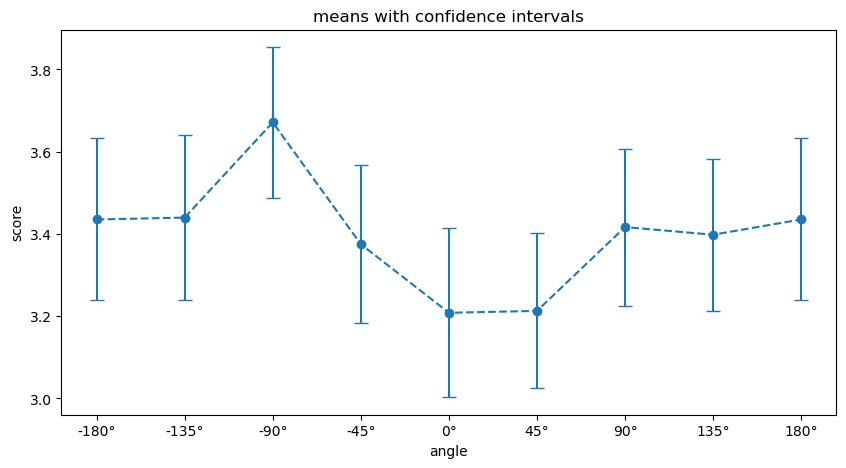

In [444]:
plt.figure(figsize=(10,5))
plt.errorbar(angles, means, [intervals1, intervals2], capsize=5, capthick=1, marker='o', fmt='--')
plt.xlabel('angle')
plt.ylabel('score')
plt.title('means with confidence intervals')
plt.savefig('means_ci.png', dpi=400, format='png')
plt.show()

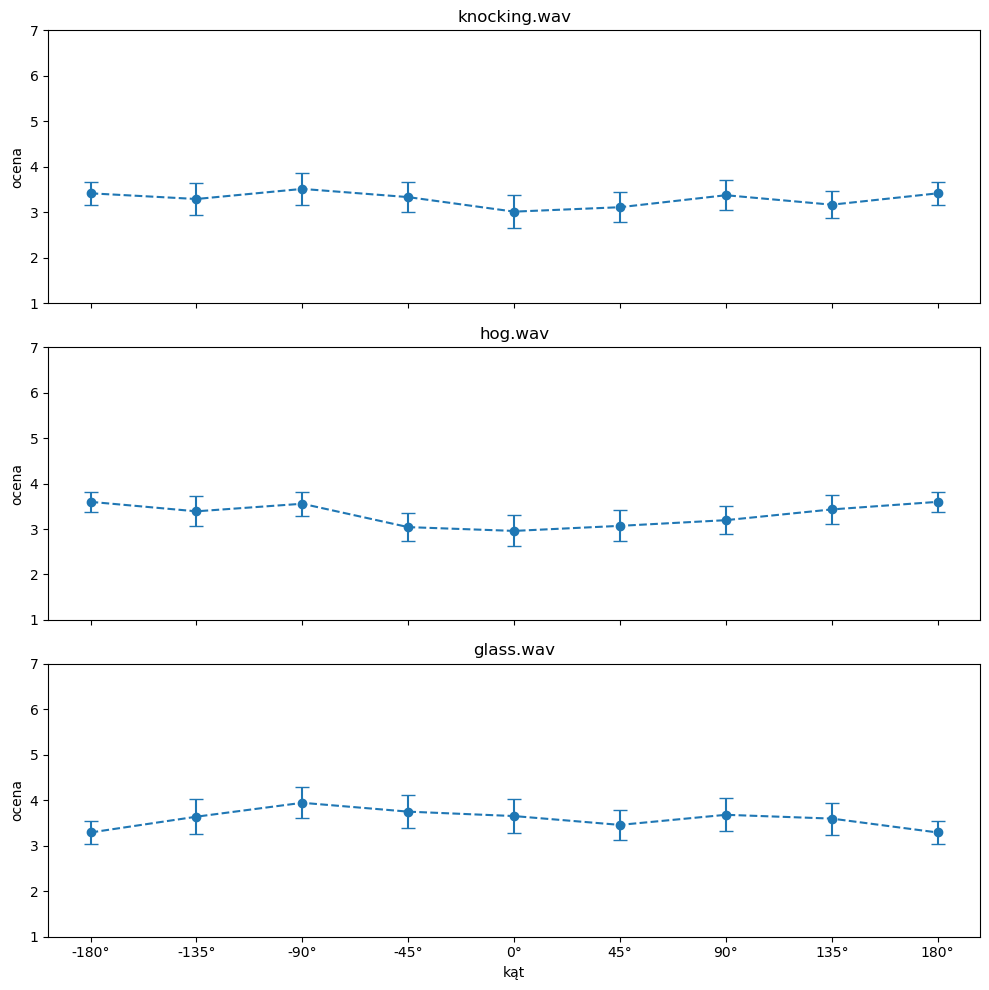

In [297]:
sounds = data['sound'].unique()
fig, ax = plt.subplots(len(sounds), figsize=(10,10), sharex=True)

for i, sound in enumerate(sounds):
    angle_groups = data[data['sound']==sound].groupby('angle').groups
    means = []
    intervals1 = []
    intervals2 = []
    for angle in angles:
        indexes = angle_groups[angle]
        angle_data = data.loc[indexes]
        mean = angle_data['score'].mean()
        intervals = st.t.interval(0.95, len(angle_data)-1, loc=mean, scale=st.sem(angle_data['score']))
        means.append(mean)
        intervals1.append(mean-intervals[0])
        intervals2.append(intervals[1]-mean)
    
    ax[i].errorbar(angles, means, [intervals1, intervals2], capsize=5, capthick=1, marker='o', fmt='--')
    ax[i].set_yticks(range(1,8))
    if i == len(sounds) - 1:
        ax[i].set_xlabel('kąt')
    ax[i].set_ylabel('ocena')
    ax[i].set_title(sound)

plt.tight_layout()
plt.savefig('means_ci_by_sounds.png', dpi=400, format='png')
plt.show()

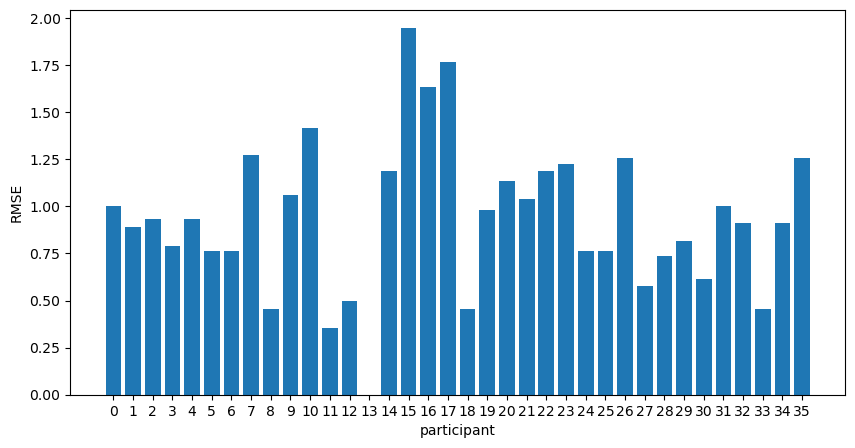

In [450]:
plt.figure(figsize=(10,5))
plt.bar(participant_ids, participants['rmse'])
plt.xticks(participant_ids)
plt.xlabel('participant')
plt.ylabel('RMSE')
plt.savefig('rmse.png', dpi=400, format='png')
plt.show()

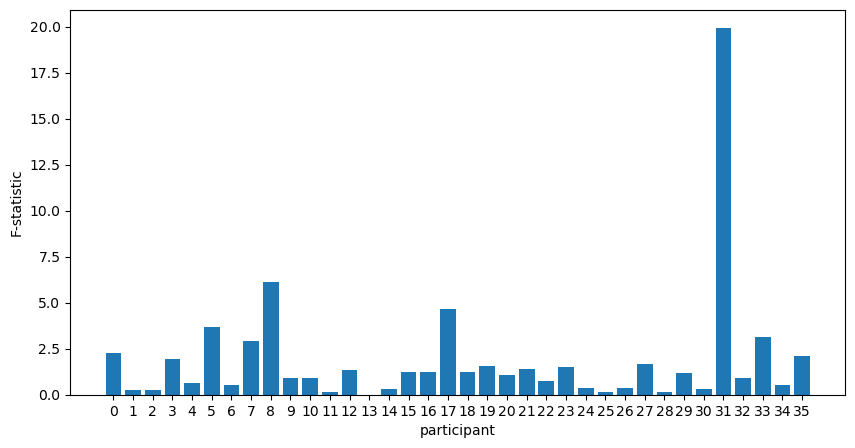

In [451]:
plt.figure(figsize=(10,5))
plt.bar(participant_ids, participants['f'])
plt.xticks(participant_ids)
plt.xlabel('participant')
plt.ylabel('F-statistic')
plt.savefig('f.png', dpi=400, format='png')
plt.show()

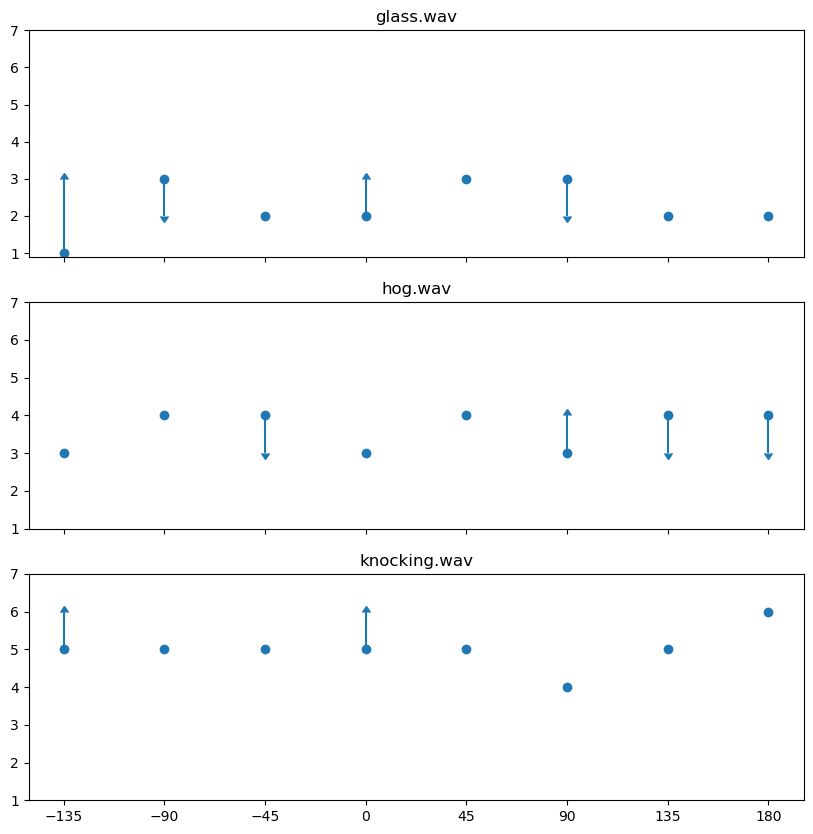

In [247]:
participant_id = 28
sounds = np.sort(data['sound'].unique())
fig, ax = plt.subplots(3, figsize=(10, 10), sharex=True)

for k, sound in enumerate(sounds):
    data_slice = data[(data['participant_id'] == participant_id) & (data['sound'] == sound)]
    first_attempt = data_slice[data_slice['repeat'] == 0].sort_values('sample')
    second_attempt = data_slice[data_slice['repeat'] == 1].sort_values('sample')
    angles = first_attempt['angle']

    uplims = []
    lolims = []
    errors = []
    for i, first_score in enumerate(first_attempt['score']):
        second_score = second_attempt['score'].iloc[i]
        lolims.append(second_score > first_score);
        uplims.append(second_score < first_score);
        errors.append(np.abs(first_score - second_score))

    ax[k].errorbar(angles, first_attempt['score'], yerr=errors, uplims=uplims, lolims=lolims, marker='o', linestyle='')
    ax[k].set_xticks(angles)
    ax[k].set_yticks(np.arange(1, 8))
    ax[k].set_title(sound)

plt.show()

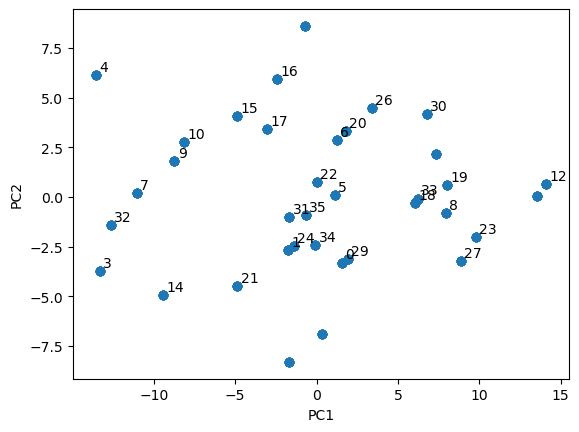

In [390]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_scores).transpose()

fig, ax = plt.subplots()
ax.scatter(pca_result[0], pca_result[1])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

for participant in participant_ids:
    ax.annotate(participant, (pca_result[0][participant] + 0.2, pca_result[1][participant] + 0.2))

plt.savefig('pca.png', dpi=400, format='png')
plt.show()

In [14]:
excluded_ids = participants[participants['f'] < 0.25]['id']
print(excluded_ids)
data = data[~data['participant_id'].isin(excluded_ids)]

2      2
11    11
13    13
25    25
28    28
Name: id, dtype: int64


In [15]:
groups = data.groupby('angle_str')['score'].apply(list)
for group in groups:
    print(np.round(st.shapiro(group).pvalue, decimals=5))
print(st.levene(*groups).pvalue)
print(st.kruskal(*groups).pvalue)
print()
groups = data.groupby('recording')['score'].apply(list)
for group in groups:
    print(np.round(st.shapiro(group).pvalue, decimals=5))
print(st.levene(*groups).pvalue)
print(st.kruskal(*groups).pvalue)
model = ols('score ~ C(angle) + C(recording) + C(angle):C(recording)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6355715939894704
0.0065865209163319775

0.0
0.0
0.0
0.015397112464290402
0.00022501243759498406


,sum_sq,df,F,PR(>F)
C(angle),34.993952,7.0,2.439723,0.017344
C(recording),34.783602,2.0,8.487701,0.000216
C(angle):C(recording),31.979839,14.0,1.114792,0.339177
Residual,2999.822581,1464.0,NaN,NaN


In [34]:
groups = data.groupby('participant_id')['score'].apply(list)
for group in groups:
    print('{:.5f}'.format(np.round(st.shapiro(group).pvalue, decimals=5)))
print()
print('{:.5f}'.format(st.levene(*groups).pvalue, decimals=5))
print(st.kruskal(*groups).pvalue)
model = ols('score ~ C(angle) + C(recording) + C(participant_id) + C(angle):C(recording) + C(angle):C(participant_id) + C(recording):C(participant_id)', data=data).fit()
sm.stats.anova_lm(model, typ=3)

0.00002
0.00006
0.00002
0.00015
0.00169
0.00001
0.00001
0.00000
0.00009
0.00260
0.00000
0.00126
0.01523
0.00264
0.00338
0.00000
0.00001
0.00000
0.00168
0.00001
0.00000
0.00001
0.00135
0.00000
0.00001
0.00002
0.00033
0.00000
0.00000
0.00001
0.00142

0.00000
4.036476844198306e-136


,sum_sq,df,F,PR(>F)
Intercept,95.291725,1.0,143.118300,3.432161e-31
C(angle),10.662247,7.0,2.287656,2.568387e-02
C(recording),10.913306,2.0,8.195328,2.921733e-04
C(participant_id),244.248118,30.0,12.227846,8.918318e-51
C(angle):C(recording),31.979839,14.0,3.430743,1.710688e-05
C(angle):C(participant_id),331.818548,210.0,2.373129,1.358503e-19
C(recording):C(participant_id),341.716398,60.0,8.553711,2.321626e-58
Residual,775.020161,1164.0,NaN,NaN


In [332]:
model = ols('score ~ C(view)', data=data_slice).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(view),18.179615,1.0,8.761401,0.003125
Residual,3083.400358,1486.0,NaN,NaN


In [36]:
in_view = data[data['view'] == True]['score']
out_view = data[data['view'] == False]['score']
print(np.around(st.shapiro(in_view).pvalue, decimals=5))
print(np.around(st.shapiro(out_view).pvalue, decimals=5))
print(np.around(st.levene(in_view, out_view).pvalue, decimals=5))
print(np.around(st.kruskal(in_view, out_view).pvalue, decimals=5))
print(np.around(st.ttest_ind(in_view, out_view, alternative='less').pvalue, decimals=5))
print(np.around(st.mannwhitneyu(in_view, out_view, alternative='less').pvalue, decimals=5))

0.0
0.0
0.84395
0.00154
0.00156
0.00077


In [28]:
print('{:.5f}'.format(ping.sphericity(data=data, dv='score', within=['angle'], subject='participant_id', alpha=0.05).pval))
print('{:.5f}'.format(ping.sphericity(data=data, dv='score', within=['recording'], subject='participant_id', alpha=0.05).pval))

'0.97053'

In [32]:
anovarm_summary = AnovaRM(data=data, depvar='score', subject='participant_id', within=['angle', 'recording'], aggregate_func='mean').fit()
print(anovarm_summary)

                     Anova
                F Value  Num DF  Den DF  Pr > F
-----------------------------------------------
angle            3.1638  7.0000 210.0000 0.0033
recording        3.0537  2.0000  60.0000 0.0546
angle:recording  2.7138 14.0000 420.0000 0.0008



In [20]:
p_values = sp.posthoc_dunn(data, group_col='angle', val_col='score')
p_values

,-135,-90,-45,0,45,90,135,180
-135,1.000000,0.057520,0.759150,0.074070,0.058623,0.974862,0.822256,0.917343
-90,0.057520,1.000000,0.027389,0.000228,0.000150,0.053502,0.033672,0.045165
-45,0.759150,0.027389,1.000000,0.138984,0.113100,0.783250,0.934685,0.839279
0,0.074070,0.000228,0.138984,1.000000,0.916511,0.079316,0.118397,0.092491
45,0.058623,0.000150,0.113100,0.916511,1.000000,0.062956,0.095640,0.073900
90,0.974862,0.053502,0.783250,0.079316,0.062956,1.000000,0.846854,0.942386
135,0.822256,0.033672,0.934685,0.118397,0.095640,0.846854,1.000000,0.903800
180,0.917343,0.045165,0.839279,0.092491,0.073900,0.942386,0.903800,1.000000


In [26]:
p_values = sp.posthoc_dunn(data, group_col='recording', val_col='score')
p_values

,glass.wav,hog.wav,knocking.wav
glass.wav,1.000000,0.003660,0.000076
hog.wav,0.003660,1.000000,0.293751
knocking.wav,0.000076,0.293751,1.000000


In [21]:
comparison_summary = pairwise_tukeyhsd(endog=data['score'], groups=data['angle_str'], alpha=0.05).summary()
comparison_summary

group1,group2,meandiff,p-adj,lower,upper,reject
-135°,-45°,-0.0484,1.0,-0.5014,0.4047,False
-135°,-90°,0.2527,0.692,-0.2004,0.7057,False
-135°,0°,-0.2581,0.6683,-0.7111,0.195,False
-135°,135°,-0.043,1.0,-0.4961,0.41,False
-135°,180°,-0.0054,1.0,-0.4584,0.4477,False
-135°,45°,-0.2688,0.6195,-0.7219,0.1842,False
-135°,90°,-0.0215,1.0,-0.4746,0.4315,False
-45°,-90°,0.3011,0.4705,-0.152,0.7541,False
-45°,0°,-0.2097,0.8553,-0.6627,0.2434,False
-45°,135°,0.0054,1.0,-0.4477,0.4584,False


In [22]:
comparison_summary = pd.read_csv(io.StringIO(comparison_summary.as_csv().split('\n', 1)[1].replace(' ', ''))).convert_dtypes()

In [23]:
comparison_summary[comparison_summary['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
13,-90°,0°,-0.5108,0.0147,-0.9638,-0.0577,True
16,-90°,45°,-0.5215,0.0115,-0.9746,-0.0685,True


In [25]:
pairwise_tukeyhsd(endog=data['score'], groups=data['recording'], alpha=0.05).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
glass.wav,hog.wav,-0.2722,0.0082,-0.4863,-0.0581,True
glass.wav,knocking.wav,-0.3589,0.0003,-0.573,-0.1448,True
hog.wav,knocking.wav,-0.0867,0.6087,-0.3008,0.1274,False


In [315]:
pairwise_tukeyhsd(endog=data_slice['score'], groups=data_slice['view'], alpha=0.05).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
False,True,-0.2283,0.0031,-0.3796,-0.077,True
